# I scraped some data, now let's use it
Scraping_Redfin_lab_notebook.ipynb runs through the process of figuring out what on earth I was doing and scraping; {potential future .py file may contain just the necessary lists and code}.

The big idea is this: there's a lot of art and even more nebulous "gut feeling" as to what price a house should be listed at. A list price that's too low runs the risk of limiting the price you get because of the anchoring effect (where the number first named skews peoples' perception of what a value should be); even if there is a bidding war with escalation clauses, the limit may be skewed by the initial listing price. A listing price that's too high seems likely to lead to a house being on the market longer, and it may discourage buyers enough that you end up with just one offer, not multiples with escalation clauses which maximize the price the eventual buyer pays for the house.

I'm trying to build a model which will take in a variety of features about a house (size, bedrooms and bathrooms, location, lot size, type of dwelling, age, etc.) and spit out a best guess for the "correct" listing price according to the market.

The purpose of this notebook is to take data scraped from Redfin, clean it, visualize it, engineer and scale the data as appropriate, and get it ready to feed into a model.

In [3]:
import pickle
# Let's unpickle this thing!
with open("listingpage_scrapes.txt", "rb") as fp:
    listing_data = pickle.load(fp)


In [87]:
import pickle
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import re

In [7]:
listings = pd.DataFrame(listing_data)
listings.head()

address    ZIP                 comm   price  beds  baths  size  \
0  10024 63rd Ave S   98178  Upper Rainier Beach  760000   4.0   2.75  2670   
1  10024 63rd Ave S   98178  Upper Rainier Beach  760000   4.0   2.75  2670   
2  10024 63rd Ave S   98178  Upper Rainier Beach  760000   4.0   2.75  2670   
3  10024 63rd Ave S   98178  Upper Rainier Beach  760000   4.0   2.75  2670   
4  10024 63rd Ave S   98178  Upper Rainier Beach  760000   4.0   2.75  2670   

                            style   lot   age status          sold  \
0  2 Stories with Basement, Tudor  6232  1921   Sold  MAR 30, 2020   
1  2 Stories with Basement, Tudor  6232  1921   Sold  MAR 30, 2020   
2  2 Stories with Basement, Tudor  6232  1921   Sold  MAR 30, 2020   
3  2 Stories with Basement, Tudor  6232  1921   Sold  MAR 30, 2020   
4  2 Stories with Basement, Tudor  6232  1921   Sold  MAR 30, 2020   

                 park  brok                                                url  
0  Off-Street Parking   3.0  https://www.redfin.com/WA/Seattle/1723-S-Fores...  
1  Off-Street Parking   3.0  https://www.redfin.com/WA/Seattle/3610-1st-Ave...  
2  Off-Street Parking   3.0  https://www.redfin.com/WA/Seattle/3052-23rd-Av...  
3  Off-Street Parking   3.0  https://www.redfin.com/WA/Seattle/924-N-87th-S...  
4  Off-Street Parking   3.0  https://www.redfin.com/WA/Seattle/8706-Phinney...

In [8]:
listings.describe()

price    beds    baths    size     lot     age    brok
count    3111.0  3111.0  3111.00  3111.0  3111.0  3111.0  3111.0
mean   760000.0     4.0     2.75  2670.0  6232.0  1921.0     3.0
std         0.0     0.0     0.00     0.0     0.0     0.0     0.0
min    760000.0     4.0     2.75  2670.0  6232.0  1921.0     3.0
25%    760000.0     4.0     2.75  2670.0  6232.0  1921.0     3.0
50%    760000.0     4.0     2.75  2670.0  6232.0  1921.0     3.0
75%    760000.0     4.0     2.75  2670.0  6232.0  1921.0     3.0
max    760000.0     4.0     2.75  2670.0  6232.0  1921.0     3.0

ENTIRE dataset is the same listing (the listing I was using to test the scraper and set response = that thing).

Holy Hannah that's a hell of a mistake.

In [9]:
with open('test_it5.txt', 'rb') as fp:
    test_scrapes = pickle.load(fp)

In [2]:
from bs4 import BeautifulSoup

In [3]:
listing_scrapes = []
dumps_list = ['listingpage_scrapes_dump100', 'listingpage_scrapes_dump200', 
              'listingpage_scrapes_dump300', 'listingpage_scrapes_dump400', 'listingpage_scrapes_dump500', 
              'listingpage_scrapes_dump600', 'listingpage_scrapes_dump700', 'listingpage_scrapes_dump800', 
              'listingpage_scrapes_dump900', 'listingpage_scrapes_dump1000', 'listingpage_scrapes_dump1100', 
              'listingpage_scrapes_dump1200']
for i in dumps_list:
    with open((i+'.txt'), 'rb') as fp:
        listing_scrapes += pickle.load(fp)

In [6]:
listing_scrapes[1]

'/WA/Seattle/762-Hayes-St-98109/unit-31/home/103951529'

In [7]:
for i in range(0, len(listing_scrapes), 2):
    listing_scrapes[i] = BeautifulSoup(listing_scrapes[i], 'html.parser')

In [119]:
def parseSoldPage(soup, url):
    """
    Grabs desired information from Redfin page for a single sold property using BeatifulSoup.
    Returns a dictionary of the desired information.
    """
    pull_digits = re.compile('[0-9.]+')
    property_dict = {}
    property_dict['address'] = soup.find('span', class_ = 'street-address').text
    property_dict['ZIP'] = soup.find('span', class_ = 'postal-code').text
    property_dict['comm'] = soup.find(string = 'Community').find_next('span', class_ = 'content text-right').text
    property_dict['price'] = pull_digits.search(soup.find('div', class_ = 'info-block price').text.replace(',', '')).group()
    try:
        property_dict['beds'] = pull_digits.search(soup.find(attrs = {'data-rf-test-id': "abp-beds"}).find('div', class_ = 'statsValue').text).group()
    except:
        property_dict['beds'] = ''
    try:
        property_dict['baths'] = pull_digits.search(soup.find(attrs = {'data-rf-test-id': "abp-baths"}).find('div', class_ = 'statsValue').text).group()
    except:
        property_dict['baths'] = ''
    try:
        property_dict['size'] = pull_digits.search(soup.find('div', class_ = 'info-block sqft').find('span', class_ = 'statsValue').text.replace(',', '')).group()
    except:
        property_dict['size'] = ''
    property_dict['style'] = soup.find(string = 'Style').find_next().text
    try:
        property_dict['lot'] = pull_digits.search(soup.find(string = 'Lot Size').find_next().text.replace(',', '')).group()
    except:
        property_dict['lot'] = ''
    property_dict['age'] = soup.find(string = 'Year Built').find_next().text
    property_dict['status'] = soup.find(attrs = {'data-rf-test-id': 'abp-status'}).find('span', class_ = 'value').text
    try:
        property_dict['sold'] = soup.find('div', class_ = "Pill Pill--red padding-vert-smallest padding-horiz-smaller font-size-smaller font-weight-bold font-color-white HomeSash margin-top-smallest margin-right-smaller").text.replace('SOLD BY REDFIN ', '')
    except:
        property_dict['sold'] = ''
    try:
        property_dict['park'] = soup.find(string = 'Parking Information').find_next().text
    except:
        property_dict['park'] = ''
    try:
        property_dict['brok'] = pull_digits.search(soup.find(string = "Buyer's Brokerage Compensation").find_next('span', class_ = 'content text-right').text).group()
    except:
        property_dict['brok'] = ''
    property_dict['url'] = url
    return property_dict

In [ ]:
pull_digits = re.compile('[0-9]+')

In [114]:
parseSoldPage(listing_scrapes[4], listing_scrapes[5])

{'address': '4042 Martin Luther King Jr. Wy S ',
 'ZIP': '98108',
 'comm': 'Columbia City',
 'price': '780000',
 'beds': '3',
 'baths': '2.5',
 'size': '2487',
 'style': '2 Story, Northwestern Contemporary',
 'lot': '5000',
 'age': '2017',
 'status': 'Sold',
 'sold': 'JUL 31, 2020',
 'park': '# of Covered Spaces: 2',
 'brok': '',
 'url': '/WA/Seattle/4042-Martin-Luther-King-Jr-Way-S-98108/home/109969582'}

In [26]:
len(data_dicts)

623

In [120]:
data_dicts = []
for i in range(0, len(listing_scrapes), 2):
    data_dicts.append(parseSoldPage(listing_scrapes[i], listing_scrapes[i+1]))

In [121]:
listings_data = pd.DataFrame(data_dicts)

listings_data.describe()

address    ZIP        comm   price  beds baths  size  \
count                  1199   1199        1199    1199  1199  1199  1199   
unique                 1195     32         111     610    10    17   600   
top     1709 18th Ave #202   98103  Queen Anne  505000     3     1  1296   
freq                      2    113          57      13   425   287    14   

                             style   lot   age status  sold  \
count                         1199  1199  1199   1199  1199   
unique                          89   713   118      1   659   
top     Condominium (Single Level)        2007   Sold         
freq                           163   134    54   1199    79   

                          park  brok  \
count                     1199  1199   
unique                      27     9   
top     # of Covered Spaces: 1   3.0   
freq                       430   986   

                                                      url  
count                                                1199  
unique                                               1195  
top     /WA/Seattle/762-Hayes-St-98109/unit-31/home/10...  
freq                                                    2

In [38]:
communities = list(listings_data['comm'].unique())

In [40]:
sorted(communities)

['Admiral',
 'Alaska Junction',
 'Alki',
 'Arbor Heights',
 'Arboretum',
 'Ballard',
 'Beach Drive',
 'Beacon Hill',
 'Belltown',
 'Belvedere Terrace',
 'Belvidere',
 'Bitter Lake',
 'Blue Ridge',
 'Boulevard Park',
 'Briarcrest',
 'Brighton',
 'Broadview',
 'Broadway',
 'Bryant',
 'Bryn Mawr',
 'Burien',
 'Campbell Hill',
 'Capitol Hill',
 'Cedar Park',
 'Central Area',
 'Columbia City',
 'Crown Hill',
 'Delridge',
 'Denny Triangle',
 'Downtown',
 'Dunlap',
 'Earlington',
 'Eastlake',
 'Fairmount',
 'Fauntleroy',
 'First Hill',
 'Fremont',
 'Gatewood',
 'Genesee',
 'Georgetown',
 'Green Lake',
 'Greenwood',
 'Haller Lake',
 'Hawthorne Hills',
 'High Point',
 'Highland Park',
 'Hillman City',
 'Jackson Park',
 'Judkins',
 'Lake City',
 'Lake Forest Park',
 'Lakeridge',
 'Lakewood',
 'Laurelhurst',
 'Leschi',
 'Licton Springs',
 'Lincoln Park',
 'Loyal Heights',
 'Madison Valley',
 'Madrona',
 'Magnolia',
 'Maple Leaf',
 'Marine View',
 'Matthews Beach',
 'Meadowbrook',
 'Montlake',
 'M

In [122]:
# removing duplicates
listings_data.drop_duplicates(keep = 'first', inplace = True, ignore_index = True)

In [54]:
styles = sorted(list(listings_data['style'].unique()))
styles

['1 1/2 Story',
 '1 1/2 Story with Basement',
 '1 1/2 Story with Basement, Cape Cod',
 '1 1/2 Story with Basement, Colonial',
 '1 1/2 Story with Basement, Craftsman',
 '1 1/2 Story with Basement, Traditional',
 '1 1/2 Story with Basement, Tudor',
 '1 1/2 Story, Cape Cod',
 '1 1/2 Story, Contemporary',
 '1 1/2 Story, Craftsman',
 '1 1/2 Story, Other (See Remarks)',
 '1 1/2 Story, Traditional',
 '1 Story',
 '1 Story with Basement',
 '1 Story with Basement, Cape Cod',
 '1 Story with Basement, Contemporary',
 '1 Story with Basement, Craftsman',
 '1 Story with Basement, Modern',
 '1 Story with Basement, Northwestern Contemporary',
 '1 Story with Basement, Other (See Remarks)',
 '1 Story with Basement, Traditional',
 '1 Story, Cape Cod',
 '1 Story, Contemporary',
 '1 Story, Craftsman',
 '1 Story, Modern',
 '1 Story, Northwestern Contemporary',
 '1 Story, Other (See Remarks)',
 '1 Story, Traditional',
 '2 Stories with Basement',
 '2 Stories with Basement, Colonial',
 '2 Stories with Basement,

In [58]:
pd.options.display.max_rows = 1000

In [59]:
listings_data.groupby('style').count()

address  ZIP  comm  price  \
style                                                                           
1 1/2 Story                                              10   10    10     10   
1 1/2 Story with Basement                                22   22    22     22   
1 1/2 Story with Basement, Cape Cod                       5    5     5      5   
1 1/2 Story with Basement, Colonial                       1    1     1      1   
1 1/2 Story with Basement, Craftsman                     21   21    21     21   
1 1/2 Story with Basement, Traditional                    3    3     3      3   
1 1/2 Story with Basement, Tudor                          7    7     7      7   
1 1/2 Story, Cape Cod                                     2    2     2      2   
1 1/2 Story, Contemporary                                 1    1     1      1   
1 1/2 Story, Craftsman                                    3    3     3      3   
1 1/2 Story, Other (See Remarks)                          1    1     1      1   
1 1/2 Story, Traditional                                  2    2     2      2   
1 Story                                                  86   86    86     86   
1 Story with Basement                                   127  127   127    127   
1 Story with Basement, Cape Cod                          27   27    27     27   
1 Story with Basement, Contemporary                       5    5     5      5   
1 Story with Basement, Craftsman                         34   34    34     34   
1 Story with Basement, Modern                             2    2     2      2   
1 Story with Basement, Northwestern Contemporary          6    6     6      6   
1 Story with Basement, Other (See Remarks)                7    7     7      7   
1 Story with Basement, Traditional                       14   14    14     14   
1 Story, Cape Cod                                         6    6     6      6   
1 Story, Contemporary                                     1    1     1      1   
1 Story, Craftsman                                        7    7     7      7   
1 Story, Modern                                           2    2     2      2   
1 Story, Northwestern Contemporary                        2    2     2      2   
1 Story, Other (See Remarks)                              2    2     2      2   
1 Story, Traditional                                      5    5     5      5   
2 Stories with Basement                                  36   36    36     36   
2 Stories with Basement, Colonial                         5    5     5      5   
2 Stories with Basement, Contemporary                     9    9     9      9   
2 Stories with Basement, Craftsman                       33   33    33     33   
2 Stories with Basement, Modern                           4    4     4      4   
2 Stories with Basement, Northwestern Contemporary        4    4     4      4   
2 Stories with Basement, Traditional                      7    7     7      7   
2 Stories with Basement, Tudor                           17   17    17     17   
2 Story                                                  42   42    42     42   
2 Story, Cape Cod                                         2    2     2      2   
2 Story, Contemporary                                     6    6     6      6   
2 Story, Craftsman                                       14   14    14     14   
2 Story, Modern                                           9    9     9      9   
2 Story, Northwestern Contemporary                        4    4     4      4   
2 Story, Other (See Remarks)                              1    1     1      1   
2 Story, Spanish/Southwestern                             1    1     1      1   
2 Story, Traditional                                      8    8     8      8   
4-Plex                                                    1    1     1      1   
Co-op                                                     3    3     3      3   
Condominium (2 Levels)                                   13   13    13     13   
Co

This can probably be boiled down to house, condo, townhouse, multi-unit. We need to drop the manufactored house(s), as those are relatively few and so drastically different from a permanent house in price that it would probably really skew the model. I want to be able to capture information about levels from this, but there are too many unknowns/unparseable. Based entirely on my intuition, the net effect of style is likely to be relatively small as different people have different style preferences and few people are likely to be willing to pay a large (1+%) premium for a particular style.

In [65]:
# Pulling out urls for split-entry to figure out which category those go into
split_entries_mask = listings_data['style'] == 'Split-Entry'
split_entries = listings_data[split_entries_mask]
split_entries['url']
# Looks like this is another word for split-level

1          /WA/Seattle/137-S-107th-St-98168/home/18660720
13         /WA/Seattle/10627-61st-Ave-S-98178/home/178357
26          /WA/Seattle/4210-NE-89th-St-98115/home/316094
93         /WA/Seattle/4859-S-Graham-St-98118/home/491247
94         /WA/Seattle/3716-SW-110th-St-98146/home/156235
117       /WA/Seattle/10718-12th-Ave-NW-98177/home/288798
235         /WA/Seattle/9629-57th-Ave-S-98118/home/175812
367       /WA/Seattle/2816-SW-Holden-St-98126/home/473228
400        /WA/Seattle/11232-56th-Ave-S-98178/home/177965
448     /WA/Seattle/11318-Meridian-Ave-N-98133/home/10...
535         /WA/Seattle/4021-25th-Ave-S-98108/home/169587
536     /WA/Seattle/1012A-NE-105th-St-98125/home/14441...
567         /WA/Seattle/8220-S-124th-St-98178/home/198887
795         /WA/Seattle/4401-NE-95th-St-98115/home/317404
872       /WA/Seattle/8808-Fremont-Ave-N-98103/home/99797
876       /WA/Seattle/10358-44th-Ave-NE-98125/home/113535
965       /WA/Seattle/11730-36th-Ave-NE-98125/home/111892
1116       /WA

In [66]:
type_dict = {'1 1/2 Story': 'house',
 '1 1/2 Story with Basement': 'house',
 '1 1/2 Story with Basement, Cape Cod': 'house',
 '1 1/2 Story with Basement, Colonial': 'house',
 '1 1/2 Story with Basement, Craftsman': 'house',
 '1 1/2 Story with Basement, Traditional': 'house',
 '1 1/2 Story with Basement, Tudor': 'house',
 '1 1/2 Story, Cape Cod': 'house',
 '1 1/2 Story, Contemporary': 'house',
 '1 1/2 Story, Craftsman': 'house',
 '1 1/2 Story, Other (See Remarks)': 'house',
 '1 1/2 Story, Traditional': 'house',
 '1 Story': 'house',
 '1 Story with Basement': 'house',
 '1 Story with Basement, Cape Cod': 'house',
 '1 Story with Basement, Contemporary': 'house',
 '1 Story with Basement, Craftsman': 'house',
 '1 Story with Basement, Modern': 'house',
 '1 Story with Basement, Northwestern Contemporary': 'house',
 '1 Story with Basement, Other (See Remarks)': 'house',
 '1 Story with Basement, Traditional': 'house',
 '1 Story, Cape Cod': 'house',
 '1 Story, Contemporary': 'house',
 '1 Story, Craftsman': 'house',
 '1 Story, Modern': 'house',
 '1 Story, Northwestern Contemporary': 'house',
 '1 Story, Other (See Remarks)': 'house',
 '1 Story, Traditional': 'house',
 '2 Stories with Basement': 'house',
 '2 Stories with Basement, Colonial': 'house',
 '2 Stories with Basement, Contemporary': 'house',
 '2 Stories with Basement, Craftsman': 'house',
 '2 Stories with Basement, Modern': 'house',
 '2 Stories with Basement, Northwestern Contemporary': 'house',
 '2 Stories with Basement, Traditional': 'house',
 '2 Stories with Basement, Tudor': 'house',
 '2 Story': 'house',
 '2 Story, Cape Cod': 'house',
 '2 Story, Contemporary': 'house',
 '2 Story, Craftsman': 'house',
 '2 Story, Modern': 'house',
 '2 Story, Northwestern Contemporary': 'house',
 '2 Story, Other (See Remarks)': 'house',
 '2 Story, Spanish/Southwestern': 'house',
 '2 Story, Traditional': 'house',
 '4-Plex': 'plex',
 'Co-op': 'condo',
 'Condominium (2 Levels)': 'condo',
 'Condominium (2 Levels), Contemporary': 'condo',
 'Condominium (2 Levels), Modern': 'condo',
 'Condominium (2 Levels), Traditional': 'condo',
 'Condominium (3+ Levels)': 'condo',
 'Condominium (3+ Levels), Contemporary': 'condo',
 'Condominium (Single Level)': 'condo',
 'Condominium (Single Level), Contemporary': 'condo',
 'Condominium (Single Level), Craftsman': 'condo',
 'Condominium (Single Level), Loft': 'condo',
 'Condominium (Single Level), Modern': 'condo',
 'Condominium (Single Level), Other (See Remarks)': 'condo',
 'Condominium (Single Level), Spanish/Southwestern': 'condo',
 'Condominium (Single Level), Traditional': 'condo',
 'Manufactured Double-Wide': 'house',
 'Multi-Level': 'house',
 'Multi-Level, Contemporary': 'house',
 'Multi-Level, Craftsman': 'house',
 'Multi-Level, Modern': 'house',
 'Multi-Level, Northwestern Contemporary': 'house',
 'Multi-Level, Traditional': 'house',
 'Residential (1+ Acre)': 'house',
 'Residential (<1 Acre)': 'house',
 'Split-Entry': 'house',
 'Split-Entry, Contemporary': 'house',
 'Split-Entry, Northwestern Contemporary': 'house',
 'Split-Entry, Other (See Remarks)': 'house',
 'Split-Entry, Traditional': 'house',
 'Townhouse': 'townhome',
 'Townhouse, Contemporary': 'townhome',
 'Townhouse, Craftsman': 'townhome',
 'Townhouse, Modern': 'townhome',
 'Townhouse, Northwestern Contemporary': 'townhome',
 'Townhouse, Townhouse': 'townhome',
 'Townhouse, Traditional': 'townhome',
 'Tri-Level': 'house',
 'Tri-Level, Contemporary': 'house',
 'Tri-Level, Craftsman': 'house',
 'Tri-Level, Modern': 'house',
 'Tri-Level, Other (See Remarks)': 'house',
 'Tri-Level, Traditional': 'house',
 'Triplex': 'plex'}
basement_dict = {'1 1/2 Story': 0,
 '1 1/2 Story with Basement': 1,
 '1 1/2 Story with Basement, Cape Cod': 1,
 '1 1/2 Story with Basement, Colonial': 1,
 '1 1/2 Story with Basement, Craftsman': 1,
 '1 1/2 Story with Basement, Traditional': 1,
 '1 1/2 Story with Basement, Tudor': 1,
 '1 1/2 Story, Cape Cod': 0,
 '1 1/2 Story, Contemporary': 0,
 '1 1/2 Story, Craftsman': 0,
 '1 1/2 Story, Other (See Remarks)': 0,
 '1 1/2 Story, Traditional': 0,
 '1 Story': 0,
 '1 Story with Basement': 1,
 '1 Story with Basement, Cape Cod': 1,
 '1 Story with Basement, Contemporary': 1,
 '1 Story with Basement, Craftsman': 1,
 '1 Story with Basement, Modern': 1,
 '1 Story with Basement, Northwestern Contemporary': 1,
 '1 Story with Basement, Other (See Remarks)': 1,
 '1 Story with Basement, Traditional': 1,
 '1 Story, Cape Cod': 0,
 '1 Story, Contemporary': 0,
 '1 Story, Craftsman': 0,
 '1 Story, Modern': 0,
 '1 Story, Northwestern Contemporary': 0,
 '1 Story, Other (See Remarks)': 0,
 '1 Story, Traditional': 0,
 '2 Stories with Basement': 1,
 '2 Stories with Basement, Colonial': 1,
 '2 Stories with Basement, Contemporary': 1,
 '2 Stories with Basement, Craftsman': 1,
 '2 Stories with Basement, Modern': 1,
 '2 Stories with Basement, Northwestern Contemporary': 1,
 '2 Stories with Basement, Traditional': 1,
 '2 Stories with Basement, Tudor': 1,
 '2 Story': 0,
 '2 Story, Cape Cod': 0,
 '2 Story, Contemporary': 0,
 '2 Story, Craftsman': 0,
 '2 Story, Modern': 0,
 '2 Story, Northwestern Contemporary': 0,
 '2 Story, Other (See Remarks)': 0,
 '2 Story, Spanish/Southwestern': 0,
 '2 Story, Traditional': 0,
 '4-Plex': 0,
 'Co-op': 0,
 'Condominium (2 Levels)': 0,
 'Condominium (2 Levels), Contemporary': 0,
 'Condominium (2 Levels), Modern': 0,
 'Condominium (2 Levels), Traditional': 0,
 'Condominium (3+ Levels)': 0,
 'Condominium (3+ Levels), Contemporary': 0,
 'Condominium (Single Level)': 0,
 'Condominium (Single Level), Contemporary': 0,
 'Condominium (Single Level), Craftsman': 0,
 'Condominium (Single Level), Loft': 0,
 'Condominium (Single Level), Modern': 0,
 'Condominium (Single Level), Other (See Remarks)': 0,
 'Condominium (Single Level), Spanish/Southwestern': 0,
 'Condominium (Single Level), Traditional': 0,
 'Manufactured Double-Wide': 0,
 'Multi-Level': 0,
 'Multi-Level, Contemporary': 0,
 'Multi-Level, Craftsman': 0,
 'Multi-Level, Modern': 0,
 'Multi-Level, Northwestern Contemporary': 0,
 'Multi-Level, Traditional': 0,
 'Residential (1+ Acre)': 0,
 'Residential (<1 Acre)': 0,
 'Split-Entry': 0,
 'Split-Entry, Contemporary': 0,
 'Split-Entry, Northwestern Contemporary': 0,
 'Split-Entry, Other (See Remarks)': 0,
 'Split-Entry, Traditional': 0,
 'Townhouse': 0,
 'Townhouse, Contemporary': 0,
 'Townhouse, Craftsman': 0,
 'Townhouse, Modern': 0,
 'Townhouse, Northwestern Contemporary': 0,
 'Townhouse, Townhouse': 0,
 'Townhouse, Traditional': 0,
 'Tri-Level': 0,
 'Tri-Level, Contemporary': 0,
 'Tri-Level, Craftsman': 0,
 'Tri-Level, Modern': 0,
 'Tri-Level, Other (See Remarks)': 0,
 'Tri-Level, Traditional': 0,
 'Triplex': 0}

In [123]:
listings_data['type'] = listings_data['style'].map(type_dict)

listings_data['basement'] = listings_data['style'].map(basement_dict)
listings_data

address    ZIP           comm    price beds  \
0                     762 Hayes St #31   98109       Westlake   445000    2   
1                       137 S 107th St   98168        Top Hat   580000    5   
2     4042 Martin Luther King Jr. Wy S   98108  Columbia City   780000    3   
3                   1709 18th Ave #202   98122   Capitol Hill   455000    1   
4                      2557 11th Ave W   98119     Queen Anne  1710000    3   
...                                 ...    ...            ...      ...  ...   
1190                  3848 47th Ave SW   98116        Genesee   693000    2   
1191              5220 42nd Ave S #101   98118  Columbia City   400000    2   
1192            1528 NE Brockman Place   98125  Olympic Hills   651000    4   
1193             3104 Western Ave #614   98121       Belltown   417000    1   
1194         583 Battery St Unit 3003N   98121       Belltown  1888000    2   

     baths  size                                       style   lot   age  \
0        1   911     Condominium (Single Level), Traditional  0.51  1977   
1        3  2084                                 Split-Entry  6543  2008   
2      2.5  2487          2 Story, Northwestern Contemporary  5000  2017   
3        1   766                  Condominium (Single Level)  7200  1998   
4        4  2730          2 Stories with Basement, Craftsman  5000  1917   
...    ...   ...                                         ...   ...   ...   
1190     1   900                                     1 Story  6201  1951   
1191     1   805          Condominium (Single Level), Modern  0.51  1962   
1192  1.75  2220  1 Story with Basement, Other (See Remarks)  0.31  1950   
1193     1   506                  Condominium (Single Level)        2007   
1194     2  1476          Condominium (Single Level), Modern        2015   

     status          sold                                 park brok  \
0      Sold  DEC 27, 2019              # of Assigned Spaces: 1  2.5   
1      Sold  MAY 25, 2018               # of Covered Spaces: 2  3.0   
2      Sold  JUL 31, 2020               # of Covered Spaces: 2        
3      Sold  FEB 27, 2019              # of Assigned Spaces: 1  3.0   
4      Sold  AUG 14, 2020  Detached Garage, Off-Street Parking  2.5   
...     ...           ...                                  ...  ...   
1190   Sold  JUL 31, 2018               # of Covered Spaces: 1  3.0   
1191   Sold                                         No Parking  3.0   
1192   Sold  JUL 28, 2017               # of Covered Spaces: 1  3.0   
1193   Sold   AUG 1, 2017              # of Assigned Spaces: 1  3.0   
1194   Sold  JUN 11, 2018              # of Assigned Spaces: 2  2.5   

                                                    url   type  basement  
0     /WA/Seattle/762-Hayes-St-98109/unit-31/home/10...  condo         0  
1        /WA/Seattle/137-S-107th-St-98168/home/18660720  house         0  
2     /WA/Seattle/4042-Martin-Luther-King-Jr-Way-S-9...  house         0  
3     /WA/Seattle/1709-18th-Ave-98122/unit-202/home/...  condo         0  
4         /WA/Seattle/2557-11th-Ave-W-98119/home/130160  house         1  
...                                                 ...    ...       ...  
1190     /WA/Seattle/3848-47th-Ave-SW-98116/home/329629  house         0  
1191  /WA/Seattle/5220-42nd-Ave-S-98118/unit-101/hom...  condo         0  
1192  /WA/Seattle/1528-NE-Brockman-Pl-98125/home/114548  house         1  
1193  /WA/Seattle/3104-Western-Ave-98121/unit-614/ho...  condo         0  
1194  /WA/Seattle/583-Battery-St-98121/unit-3003N/ho...  condo         0  

[1195 rows x 17 columns]

In [124]:
converted_data = listings_data
converted_data['price'] = pd.to_numeric(converted_data['price'], 'coerce')
converted_data['beds'] = pd.to_numeric(converted_data['beds'], 'coerce')
converted_data['baths'] = pd.to_numeric(converted_data['baths'], 'coerce')
converted_data['lot'] = pd.to_numeric(converted_data['lot'], 'coerce')
converted_data['brok'] = pd.to_numeric(converted_data['brok'], 'coerce')
converted_data['age'] = pd.to_datetime(converted_data['age'], 'coerce')
converted_data['sold'] = pd.to_datetime(converted_data['sold'], 'coerce')
converted_data['size'] = pd.to_numeric(converted_data['size'], 'coerce')

In [85]:
low_price = converted_data['price'] < 100000
cheap_houses = converted_data[low_price]
cheap_houses

address    ZIP                 comm  price  beds  \
4                  2557 11th Ave W   98119           Queen Anne    171   3.0   
9                   647 NW 51st St   98107              Ballard     97   3.0   
12                 7310 7th Ave SW   98106        Highland Park     50   3.0   
18                 4612 S Pearl St   98118        Columbia City     81   3.0   
20          1505 15th Ave S Unit A   98144        N Beacon Hill     68   2.0   
28               10041 30th Ave SW   98146        Arbor Heights     87   4.0   
36       1614 Summit Ave Unit S205   98122         Capitol Hill     27   NaN   
82      211 Summit Ave E Unit S320   98102             Broadway     37   1.0   
94                3716 SW 110th St   98146        Arbor Heights     71   3.0   
109                8616 5th Ave NE   98115           Maple Leaf     79   4.0   
118                3121 23rd Ave S   98144          Beacon Hill     70   3.0   
145               2523 NE 110th St   98125      Victory Heights     87   4.0   
157            440 NE 73rd St #202   98115           Green Lake     51   2.0   
168             9220 Fremont Ave N   98103            Greenwood     69   3.0   
171        4317 26th Ave SW Unit B   98106             Delridge     55   3.0   
177         2040 Waverly Pl N #204   98109             Westlake     83   2.0   
179    8601 Delridge Way SW Unit A   98106             Delridge     47   3.0   
183      655 Crockett St Unit A105   98109             Westlake     53   1.0   
191                 2264 N 56th St   98103          Wallingford    100   3.0   
199               9741 48th Ave NE   98115       Matthews Beach     88   4.0   
201                11747 64th Ln S   98178               Skyway     57   5.0   
238   13201 Linden Ave N Unit 402A   98133          Bitter Lake     37   2.0   
241             4922 C S Willow St   98118         Hillman City     54   2.0   
242                 2337 N 64th St   98103           Green Lake     81   3.0   
250          5650 24th Ave NW #514   98107              Ballard     34   1.0   
253                8552 2nd Ave NE   98115           Maple Leaf     96   5.0   
258               4112 36th Ave SW   98126         West Seattle     67   2.0   
265               10070 65th Ave S   98178        Rainier Beach     79   5.0   
270            11002 Rainier Ave S   98178            Lakeridge    180   3.0   
280                3404 NE 57th St   98105               Bryant    126   4.0   
285                 825 NE 70th St   98115           Green Lake    140   2.0   
286               5233 S Farrar St   98118          Seward Park    130   4.0   
302                2018 14th Ave S   98144        N Beacon Hill     90   3.0   
328       509 E Harrison St Unit A   98102         Capitol Hill     40   2.0   
332        11529 Sand Point Way NE   98125       Matthews Beach     72   3.0   
333            225 NE 65th St #304   98115           Green Lake     61   2.0   
338         9219 Linden Ave Unit C   98103            Greenwood     55   2.0   
345             4708 Midvale Ave N   98103          Wallingford     66   2.0   
349           7366 Woodlawn Ave NE   98115           Green Lake     89   3.0   
351      506 E Howell St Unit E507   98122             Broadway     53   2.0   
356                4426 29th Ave W   98199             Magnolia    120   4.0   
365              7747 S Mission Dr   98178            Bryn Mawr     49   3.0   
368        7023 35th Ave NE Unit B   98115              Ravenna     67   3.0   
388              2929 1st Ave #313   98121             Belltown     46   1.0   
397               4421 40th Ave SW   98116              Genesee     85   4.0   
412               6046 Beach Dr SW   98136              Seaview    165   5.0   
414                3041 NW 57th St   98107          Sunset Hill     77   2.0   
444         1766 NW 59th St Unit B   98107              Ballard     67   2.0   
445                  534 N 75th St   98103           Green Lake    120   3.0   
454     4343 Roosevelt Way N

All the low prices seem like inappropriate truncations (formatting inconsistencies for these listings). Went back and changed the function definition such that it now uses regex (```pull_digits = re.compile('[0-9.]+')``` and ```pull_digits.findall(soup.find. . .)```) to pull all digits. Generalized this solution to beds, bath, size, lot, and brok in hopes of improving performance.

In [125]:
converted_data.describe()

price         beds        baths           lot         brok  \
count  1.195000e+03  1177.000000  1188.000000   1061.000000  1185.000000   
mean   6.791558e+05     2.836024     2.034091   3983.753902     2.916084   
std    3.087472e+05     1.150773     0.888056   2828.379636     0.219382   
min    8.000000e+04     1.000000     0.750000      0.250000     0.560000   
25%    4.790000e+05     2.000000     1.375000   1309.000000     3.000000   
50%    6.200000e+05     3.000000     1.750000   4080.000000     3.000000   
75%    8.030000e+05     4.000000     2.750000   6000.000000     3.000000   
max    3.000000e+06     9.000000     6.000000  10880.000000     5.000000   

          basement  
count  1195.000000  
mean      0.331381  
std       0.470907  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

In [126]:
converted_data['park'].unique()

array(['# of Assigned Spaces: 1', '# of Covered Spaces: 2',
       'Detached Garage, Off-Street Parking', '# of Covered Spaces: 1',
       'Off-Street Parking', '# of Covered Spaces: 3', 'No Parking',
       '# of Assigned Spaces: 2', '# of Parking Spaces (Total): 3',
       '# of Parking Spaces (Total): 6', 'No Parking, Off-Street Parking',
       'Parking Space Number: 151', 'Attached Garage, Off-Street Parking',
       'Detached Carport, Off-Street Parking', '# of Covered Spaces: 4',
       'Individual Garage', '# of Assigned Spaces: 3',
       'Parking Space Number: B-17 possibly', '', 'Attached Garage',
       '# of Parking Spaces (Total): 4', 'Common Garage',
       'Off-Street Parking, Uncovered', '# of Assigned Spaces: 5',
       'Detached Garage', 'Carport', 'Parking Space Number: 4'],
      dtype=object)

In [127]:
converted_data.drop(columns = 'park', inplace = True)

In [131]:
# Dropping columns that are unnecessary for the model a priori
converted_data.drop(columns = ['address', 'comm', 'style', 'status', 'url'], inplace = True)

# Feature engineering
Let's import some things and get started with a Pairplot, shall we?

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [133]:
converted_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195 entries, 0 to 1194
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ZIP       1195 non-null   object        
 1   price     1195 non-null   int64         
 2   beds      1177 non-null   float64       
 3   baths     1188 non-null   float64       
 4   size      1195 non-null   object        
 5   lot       1061 non-null   float64       
 6   age       1193 non-null   datetime64[ns]
 7   sold      859 non-null    datetime64[ns]
 8   brok      1185 non-null   float64       
 9   type      1195 non-null   object        
 10  basement  1195 non-null   int64         
dtypes: datetime64[ns](2), float64(4), int64(2), object(3)
memory usage: 102.8+ KB


In [139]:
listings_data['lot'] = pd.to_numeric(listings_data['lot'], 'coerce')

# I saw a few listings for townhouses with 1 sq ft token lot size and sub-1 acres
small_lot = (listings_data['lot'] < 1)
small_lot_listings = listings_data[small_lot]
small_lot_listings
# Scrolling through dataframe and grabbing urls confirmed that sub-1 lot sizes are in acres.

ZIP    price  beds  baths  size   lot        age       sold  brok  \
0     98109   445000   2.0   1.00   911  0.51 1977-01-01 2019-12-27   2.5   
8     98107   558000   1.0   1.00   726  0.51 2008-01-01 2017-09-29   3.0   
16    98103   278000   1.0   1.00   623  0.39 1979-01-01        NaT   3.0   
24    98121   500000   1.0   1.00   787  0.48 1989-01-01 2019-04-09   3.0   
46    98115   471000   2.0   2.00   833  0.42 2005-01-01 2017-02-01   3.0   
47    98178   532000   5.0   1.75  2270  0.27 1962-01-01        NaT   3.0   
48    98105  1490000   5.0   2.75  3340  0.29 1955-01-01 2020-09-23   2.5   
54    98119   375000   1.0   1.00   591  0.59 1949-01-01 2020-01-09   3.0   
61    98102   705000   2.0   1.75  1308  0.42 1990-01-01 2018-12-05   3.0   
74    98103   425000   1.0   1.50  1066  0.36 1981-01-01 2019-06-12   3.0   
77    98133   287000   2.0   1.00   837  0.56 1988-01-01 2017-11-22   2.5   
79    98109   500000   2.0   1.00   777  0.27 1990-01-01 2019-06-19   3.0   
83    98103   362000   1.0   1.00   594  0.72 2006-01-01 2018-05-24   2.5   
108   98109   596000   2.0   1.75   834  0.46 1991-01-01 2017-08-09   2.5   
111   98121   717500   1.0   1.00   940  0.96 2016-01-01        NaT   3.0   
150   98118   900000   7.0   3.00  3960  0.29 1958-01-01 2020-07-10   3.0   
163   98178   760000   4.0   3.00  2780  0.43 1956-01-01 2018-11-16   3.0   
178   98177  1170000   4.0   4.00  3150  0.33 1962-01-01 2019-02-20   2.5   
206   98103   560000   1.0   1.00   729  0.54 2007-01-01        NaT   3.0   
211   98115   280000   NaN   1.00   488  0.42 2007-01-01        NaT   3.0   
222   98105  1255000   4.0   3.00  2970  0.31 1954-01-01 2020-09-23   3.0   
223   98103   385000   1.0   1.00   606  0.57 1969-01-01 2017-11-30   3.0   
243   98122   505000   1.0   1.00   688  0.29 1989-01-01 2017-10-02   3.0   
248   98102   520000   1.0   1.00   651  0.33 1989-01-01 2017-10-17   3.0   
262   98119   300000   1.0   1.00   643  0.59 1949-01-01 2020-01-09   3.0   
269   98109   460000   2.0   1.00   717  0.35 1989-01-01 2019-11-05   3.0   
279   98118   275000   1.0   1.00   657  0.51 1962-01-01        NaT   3.5   
283   98116  1035000   4.0   3.75  4200  0.26 1925-01-01        NaT   3.0   
295   98115   607000   2.0   1.75   854  0.42 2006-01-01 2018-03-07   3.0   
296   98121   479000   1.0   1.00   586  0.58 2008-01-01 2017-07-07   3.0   
319   98109   385000   1.0   1.00   748  0.33 1930-01-01 2016-10-18   3.0   
323   98178   490000   3.0   1.75  1580  0.38 1945-01-01 2018-05-17   2.5   
343   98116   624950   2.0   1.75  1013  0.93 1973-01-01 2020-08-14   3.0   
360   98121   950000   2.0   2.00  1156  0.96 2015-01-01 2019-12-12   3.0   
361   98109   810000   2.0   1.75  1349  0.39 1997-01-01 2016-09-08   3.0   
382   98115   279500   1.0   1.00   643  0.92 1982-01-01        NaT   3.0   
385   98168   400000   3.0   2.00  2880  0.26 1948-01-01 2020-09-25   3.0   
387   98109   380000   1.0   1.00   843  0.51 2009-01-01 2016-10-19   3.0   
400   98178   377000   3.0   2.00  1540  0.26 1963-01-01        NaT   3.0   
412   98136  1651000   5.0   3.00  2860  0.34 1931-01-01 2020-07-09   2.5   
416   98116   370000   1.0   1.00   603  0.26 2006-01-01 2018-03-12   3.0   
432   98199   515000   3.0   1.75  1221  0.40 1969-01-01 2018-11-01   3.0   
437   98103   360000   2.0   1.00   830  0.43 1969-01-01        NaT   3.0   
465   98178   660000   4.0   2.00  3400  0.28 1936-01-01 2020-07-31   3.0   
481   98199   460000   2.0   2.00  1219  0.27 1996-01-01 2019-10-24   3.0   
483   98103   394950   1.0   0.75   613  0.28 1990-01-01 2019-12-11   3.0   
490   98119   524000   1.0   1.00   846  0.42 2003-01-01 2017-06-09   3.0   
492   98119   565600   2.0   1.75  1332  0.32 1977-01-01 2017-02-06   3.0   
505   98118  2899000   5.0   3.50  5041  0.44 2017-01-01        NaT   2.5   
523   98178   350000   2.0   1.75  1600  0.37 1948-01-01        NaT   3.0   
540   98146   865000   5.0   1.75  2500  0.56 1958-01-01        NaT   3.0   
542 

In [140]:
converted_data['lot'].fillna(0, inplace = True)
converted_data

ZIP    price  beds  baths  size      lot        age       sold  brok  \
0     98109   445000   2.0   1.00   911     0.51 1977-01-01 2019-12-27   2.5   
1     98168   580000   5.0   3.00  2084  6543.00 2008-01-01 2018-05-25   3.0   
2     98108   780000   3.0   2.50  2487  5000.00 2017-01-01 2020-07-31   NaN   
3     98122   455000   1.0   1.00   766  7200.00 1998-01-01 2019-02-27   3.0   
4     98119  1710000   3.0   4.00  2730  5000.00 1917-01-01 2020-08-14   2.5   
...     ...      ...   ...    ...   ...      ...        ...        ...   ...   
1190  98116   693000   2.0   1.00   900  6201.00 1951-01-01 2018-07-31   3.0   
1191  98118   400000   2.0   1.00   805     0.51 1962-01-01        NaT   3.0   
1192  98125   651000   4.0   1.75  2220     0.31 1950-01-01 2017-07-28   3.0   
1193  98121   417000   1.0   1.00   506     0.00 2007-01-01 2017-08-01   3.0   
1194  98121  1888000   2.0   2.00  1476     0.00 2015-01-01 2018-06-11   2.5   

       type  basement  
0     condo         0  
1     house         0  
2     house         0  
3     condo         0  
4     house         1  
...     ...       ...  
1190  house         0  
1191  condo         0  
1192  house         1  
1193  condo         0  
1194  condo         0  

[1195 rows x 11 columns]

In [141]:
converted_data.loc[(converted_data.type == 'house') & (converted_data.lot < 1), 'lot'] = converted_data['lot']*43560

In [146]:
converted_data['lot'].describe()

count     1195.000000
mean      3968.984971
std       3501.100753
min          0.000000
25%       1072.000000
50%       4000.000000
75%       6000.000000
max      29620.800000
Name: lot, dtype: float64

In [149]:
converted_data['brok'].fillna(converted_data['brok'].mode()[0], inplace = True)

In [154]:
# Struggling with sold date; I expect this to be really informative AND there are lots of missing values
sold_dates = converted_data.sold
sold_dates.mean()
# Would kind of like to try putting it to median, but not willing to take the time to do it now.
converted_data['sold'].fillna(sold_dates.mean(), inplace = True)

In [155]:
converted_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195 entries, 0 to 1194
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ZIP       1195 non-null   object        
 1   price     1195 non-null   int64         
 2   beds      1177 non-null   float64       
 3   baths     1188 non-null   float64       
 4   size      1195 non-null   object        
 5   lot       1195 non-null   float64       
 6   age       1193 non-null   datetime64[ns]
 7   sold      1195 non-null   datetime64[ns]
 8   brok      1195 non-null   object        
 9   type      1195 non-null   object        
 10  basement  1195 non-null   int64         
dtypes: datetime64[ns](2), float64(3), int64(2), object(4)
memory usage: 102.8+ KB


In [156]:
# Only a few null values, and those are for things like beds and baths that I think will be critical
converted_data.dropna(inplace = True)

In [173]:
type_dummies = pd.get_dummies(converted_data, columns = ['type'], drop_first = True)
type_dummies['ZIP'] = pd.to_numeric(type_dummies['ZIP'], 'coerce')
type_dummies['size'] = pd.to_numeric(type_dummies['size'], 'coerce')
type_dummies['brok'] = pd.to_numeric(type_dummies['brok'], 'coerce')

In [175]:
type_dummies.dropna(inplace = True)
type_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 0 to 1194
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ZIP            1168 non-null   int64         
 1   price          1168 non-null   int64         
 2   beds           1168 non-null   float64       
 3   baths          1168 non-null   float64       
 4   size           1168 non-null   float64       
 5   lot            1168 non-null   float64       
 6   age            1168 non-null   datetime64[ns]
 7   sold           1168 non-null   datetime64[ns]
 8   brok           1168 non-null   float64       
 9   basement       1168 non-null   int64         
 10  type_house     1168 non-null   uint8         
 11  type_plex      1168 non-null   uint8         
 12  type_townhome  1168 non-null   uint8         
dtypes: datetime64[ns](2), float64(5), int64(3), uint8(3)
memory usage: 103.8 KB


/Users/chesh1/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


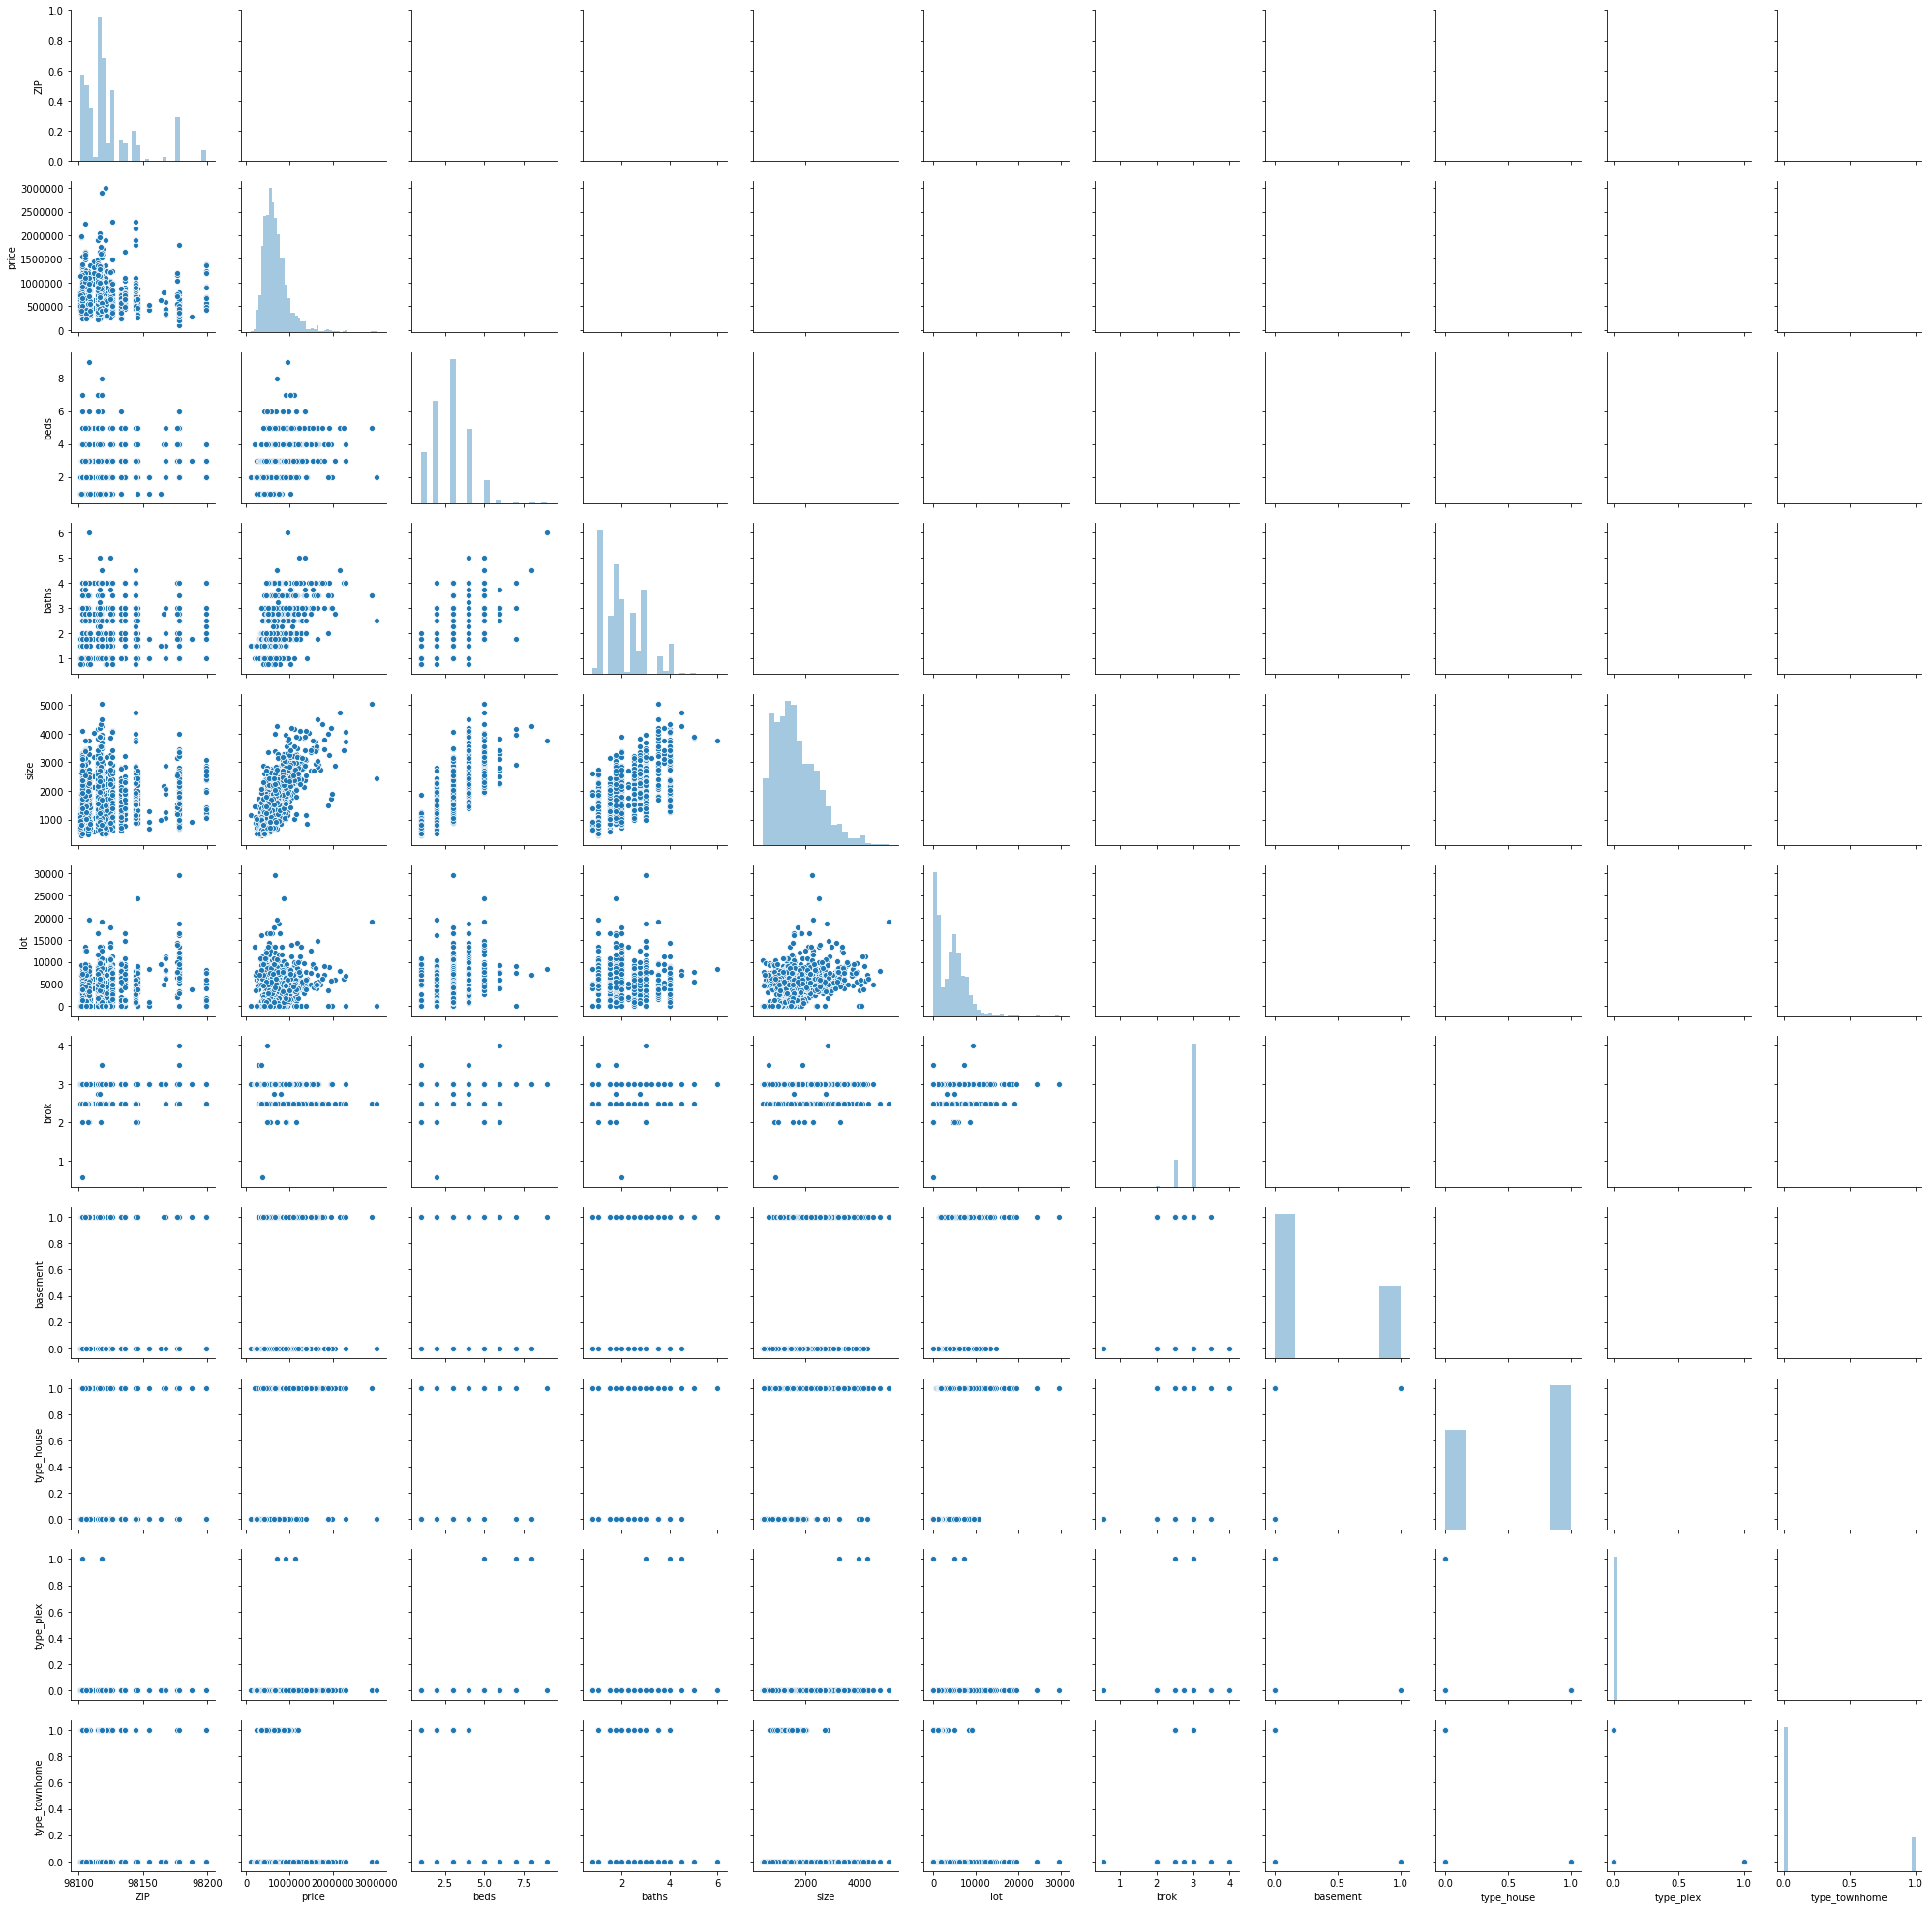

In [176]:
listing_pairplot = sbn.PairGrid(type_dummies, diag_sharey=False)
listing_pairplot.map_lower(sbn.scatterplot)
listing_pairplot.map_diag(sbn.distplot, kde=False)

Nothing looks too concerning yet, though I'm annoyed that the sold date didn't graph. Next step is zooming in on zip and price to look for clusters I can create, then scaling features and repeating the paired plot.

In [190]:
type_dummies['ppsqft'] = type_dummies['price']/type_dummies['size']
max_ppsqft_by_ZIP = type_dummies.groupby('ZIP').agg({'ppsqft': 'max'}).sort_values(by = 'ppsqft', ascending = False)
mean_ppsqft_by_ZIP = type_dummies.groupby('ZIP').agg({'ppsqft': 'mean'}).sort_values(by = 'ppsqft', ascending = False)
both_ppsqft_by_ZIP = mean_ppsqft_by_ZIP.join(max_ppsqft_by_ZIP, lsuffix = 'mean', rsuffix = 'max')
both_ppsqft_by_ZIP

ppsqftmean    ppsqftmax
ZIP                           
98101  802.512961  1016.081871
98121  786.081001  1279.132791
98164  649.284254   649.284254
98102  644.196878  1125.866051
98109  605.686659   816.942551
98122  601.945259   853.080569
98119  576.046380   772.715909
98107  538.947402   897.260274
98155  522.855296   604.617605
98112  510.318873   804.054054
98104  485.185185   485.185185
98103  478.943852   768.175583
98105  475.292537   776.666667
98115  458.610470  1627.906977
98144  448.415199   742.574257
98116  442.142293   770.000000
98177  439.687735   605.042017
98199  430.294330   537.401575
98117  425.234565   631.666667
98136  408.930960   679.487179
98126  389.559360   639.344262
98133  382.497742   532.407407
98125  379.199581   656.250000
98108  378.526568   617.592593
98166  368.493782   368.493782
98118  361.895831   790.000000
98106  353.592584   627.430556
98134  331.658291   331.658291
98146  326.714216   595.505618
98188  295.591398   295.591398
98178  273.639970   554.794521
98168  247.465992   394.339623

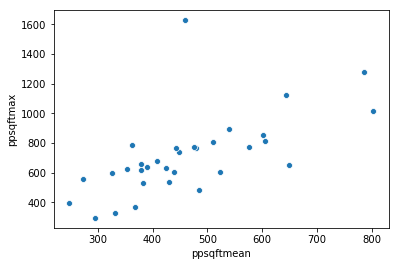

In [192]:
sbn.scatterplot(x = both_ppsqft_by_ZIP['ppsqftmean'], y = both_ppsqft_by_ZIP['ppsqftmax'])

In [198]:
mean_ppsqft_index = list(mean_ppsqft_by_ZIP.index)
mean_ppsqft_index

[98101,
 98121,
 98164,
 98102,
 98109,
 98122,
 98119,
 98107,
 98155,
 98112,
 98104,
 98103,
 98105,
 98115,
 98144,
 98116,
 98177,
 98199,
 98117,
 98136,
 98126,
 98133,
 98125,
 98108,
 98166,
 98118,
 98106,
 98134,
 98146,
 98188,
 98178,
 98168]

In [205]:
zip_sorted_listings = type_dummies
zip_sorted_listings['ZIP'] = zip_sorted_listings.to_string(columns = ['ZIP'])
zip_sorted_listings
#zip_sorted_listings['ZIP_cat'] = pd.Categorical(zip_sorted_listings['ZIP'], categories = mean_ppsqft_index, ordered = True)
#sbn.boxplot(zip_sorted_listings['ZIP_cat'], zip_sorted_listings['price'])

KeyboardInterrupt: 

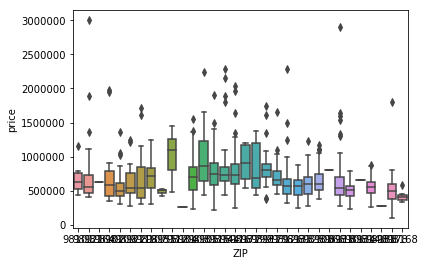

In [197]:
sbn.boxplot(type_dummies['ZIP'], type_dummies['price'], order = mean_ppsqft_index)